# EconML Example: Analyzing the Effects of Education Programs on Student Performance

**Goal.** Use the [UCI Student Performance dataset](https://archive.ics.uci.edu/dataset/320/student+performance) to estimate the **causal effect** of a school-based educational support program on students' final grades, and to explore **which student groups benefit the most**.

**Tools.**

- **EconML**: Causal inference with machine learning (treatment effect estimation).
- **ucimlrepo**: Programmatic access to the UCI ML Repository dataset.
- **Our wrapper (`econml_utils.py`)**: Utility layer to standardize how we load data and build EconML models.

This notebook is designed to be **self-contained** so a reader with no prior context could understand the dataset, the causal question, and how EconML is used here.

# Notebook Summary

In this example we will:

1. **Load** the Student Performance dataset directly from the UCI ML Repository using `ucimlrepo`.
2. **Clean** and lightly encode the raw data (e.g., convert `yes`/`no` to `0`/`1`).
3. **Define the causal setup**:
   - Outcome (final grade `G3`)
   - Treatment (school support program `schoolsup`)
   - Features (X) and controls (W)
4. **Explore the data**:
   - Basic distributions of grades and key demographics
   - Differences between treated vs. control students
5. **Fit EconML models** to estimate:
   - Average Treatment Effect (ATE)
   - Heterogeneous effects (CATEs) across demographic groups.


# Student Performance EconML Demonstration

## Load the Student Performance dataset (UCI ML Repository)

We use the `ucimlrepo` Python package to download the **Student Performance** dataset
(ID = 320) directly from the UCI Machine Learning Repository.

The helper function `load_student_data()` in `econml_utils.py` wraps this logic:

- By default it calls `fetch_ucirepo(id=320)` and concatenates the features (`X`)
  and targets (`y`) into a single `pandas.DataFrame`.
- As a fallback, it can also load from a local CSV file if needed.

In [1]:
# If ucimlrepo is not already installed in the Docker image, install it.
# You can comment this out once the environment is set up.
# !pip install -q ucimlrepo
# !pip install scikit-learn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

from econml_utils import (
    load_student_data,
    clean_student_data,
    make_default_config,
    split_y_t_x_w,
    summarize_treatment,
    build_econml_estimator,
    fit_econml_estimator,
    estimate_ate,
    estimate_cate_by_subgroup
)

In [2]:
# Load the raw dataset from UCI.
df_raw = load_student_data(source="ucimlrepo")

print(f"Raw dataset shape: {df_raw.shape}")
df_raw.head()

df_raw.info()
df_raw.describe(include="all").transpose().head(15)

Raw dataset shape: (649, 33)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 649 entries, 0 to 648
Data columns (total 33 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   school      649 non-null    object
 1   sex         649 non-null    object
 2   age         649 non-null    int64 
 3   address     649 non-null    object
 4   famsize     649 non-null    object
 5   Pstatus     649 non-null    object
 6   Medu        649 non-null    int64 
 7   Fedu        649 non-null    int64 
 8   Mjob        649 non-null    object
 9   Fjob        649 non-null    object
 10  reason      649 non-null    object
 11  guardian    649 non-null    object
 12  traveltime  649 non-null    int64 
 13  studytime   649 non-null    int64 
 14  failures    649 non-null    int64 
 15  schoolsup   649 non-null    object
 16  famsup      649 non-null    object
 17  paid        649 non-null    object
 18  activities  649 non-null    object
 19  nursery     649 non-n

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
school,649,2,GP,423,NaN,NaN,NaN,NaN,NaN,NaN,NaN
sex,649,2,F,383,NaN,NaN,NaN,NaN,NaN,NaN,NaN
age,649.0,NaN,NaN,NaN,16.744222,1.218138,15.0,16.0,17.0,18.0,22.0
address,649,2,U,452,NaN,NaN,NaN,NaN,NaN,NaN,NaN
famsize,649,2,GT3,457,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Pstatus,649,2,T,569,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Medu,649.0,NaN,NaN,NaN,2.514638,1.134552,0.0,2.0,2.0,4.0,4.0
Fedu,649.0,NaN,NaN,NaN,2.306626,1.099931,0.0,1.0,2.0,3.0,4.0
Mjob,649,5,other,258,NaN,NaN,NaN,NaN,NaN,NaN,NaN
Fjob,649,5,other,367,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Overall Dataset and Important Variables

We use the UCI *Student Performance* dataset. The outcome is the student’s final grade:

- **Outcome (Y):** `G3` = final grade on a **0–20** scale.

We treat “extra educational support” as the program:

- **Treatment (T):** `schoolsup` = extra educational support (yes/no, encoded as 0/1 in our cleaned data).

We analyze heterogeneity across “demographics / SES proxies” including:
- `sex` (gender), `Medu` (mother’s education), `address` (urban/rural), and `higher` (plans for higher education).

## Cleaning and defining Y, T, X, W

The original dataset includes:

- Demographic and family information (e.g., `sex`, `age`, `Medu`, `Fedu`)
- Study behavior and school-related variables (e.g., `studytime`, `absences`)
- Several support flags:
  - `schoolsup`: extra educational school support (yes/no)
  - `famsup`: family educational support (yes/no)
  - `paid`: extra paid classes (yes/no)
- Three grade columns:
  - `G1`, `G2`: first and second period grades
  - `G3`: final grade

For this project we adopt the following **causal framing**:

- **Outcome (Y)**: `G3` - the final course grade.
- **Treatment (T)**: `schoolsup` - interpreted as participation in a school support program.
- **Features (X)** (treatment-effect heterogeneity):
  - `sex`, `age`, `Medu`, `Fedu`, `studytime`, `failures`, `higher`, `internet`, `absences`
- **Controls (W)** (confounding adjustment):
  - `G1`, `G2`, `famsup`, `paid`

The function `clean_student_data()`:

- Converts `yes`/`no` flags to 0/1
- Encodes a few categorical variables as 0/1 (e.g., `sex`, `school`, `address`, `Pstatus`)

The helper `make_default_config()` stores these column choices in an `EconMLEducationConfig` object that we will pass to EconML later.

In [3]:
# Clean the raw data (e.g., map yes/no to 0/1, encode a few key categories).
df = clean_student_data(df_raw)

# Build the default causal configuration (Y, T, X, W).
config = make_default_config()
config

EconMLEducationConfig(outcome_col='G3', treatment_col='schoolsup', x_cols=['sex', 'age', 'Medu', 'Fedu', 'studytime', 'failures', 'higher', 'internet', 'absences'], w_cols=['G1', 'G2', 'famsup', 'paid'], estimator_type='linear_dml')

## Causal question and identification strategy

**Causal question:** What is the effect of receiving extra school support (`schoolsup`) on final grade (`G3`)?

Because this is observational data (not randomized assignment), a naive comparison between supported vs non supported students may be biased. We therefore use **Double Machine Learning (DML)** to estimate causal effects while controlling for confounders.

**Identification assumption (unconfoundedness):** conditional on observed covariates (prior grades and student/family/school characteristics), the assignment to extra support is “as good as random.” In practice, this means we assume we have measured the key drivers that influence both:
- whether a student gets extra support, and
- how they perform academically.

**Model roles:**
- `W` (controls): variables used to adjust for confounding (e.g., prior grades `G1`, `G2`, study time, failures, etc.).
- `X` (effect modifiers): the subgroup / demographic features we use to study heterogeneous effects (CATE), such as `sex`, `Medu`, `address`, `higher`.

In [4]:
# How many treated vs control students, and what are their average final grades?
treatment_summary = summarize_treatment(df, config)
treatment_summary

,treatment,count,mean_outcome,std_outcome
0,0,581,11.979346,3.316040
1,1,68,11.279412,2.304088


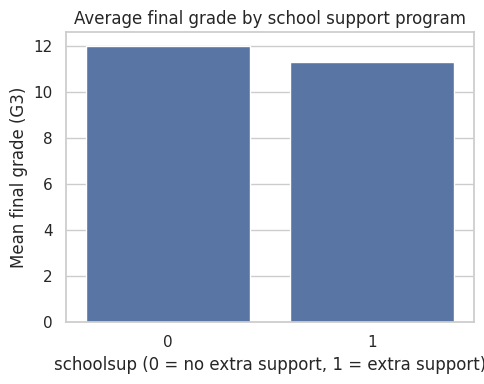

In [5]:
plt.figure(figsize=(5, 4))
sns.barplot(
    data=treatment_summary,
    x="treatment",
    y="mean_outcome",
)
plt.xlabel("schoolsup (0 = no extra support, 1 = extra support)")
plt.ylabel("Mean final grade (G3)")
plt.title("Average final grade by school support program")
plt.tight_layout()
plt.show()

## Exploratory data analysis (EDA)

Before fitting causal models, we briefly explore the outcome and treatment:

- Distribution of final grades `G3`  
- How `G3` differs between treated and control students (`schoolsup`)  
- Basic covariate balance (do treated students look different from controls?)

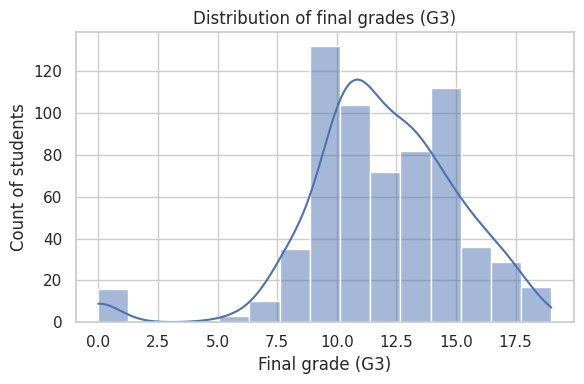

In [6]:
# Histogram of G3
plt.figure(figsize=(6, 4))
sns.histplot(df["G3"], bins=15, kde=True)
plt.xlabel("Final grade (G3)")
plt.ylabel("Count of students")
plt.title("Distribution of final grades (G3)")
plt.tight_layout()
plt.show()

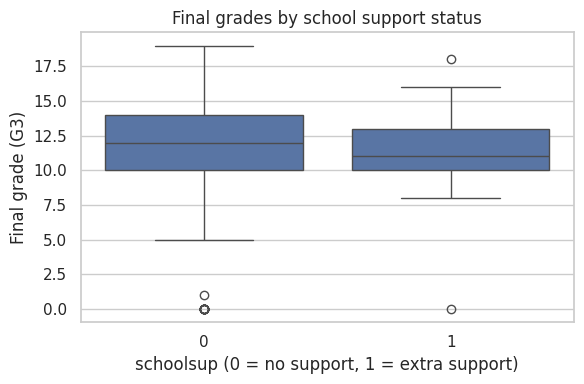

In [7]:
# Boxplot of G3 by schoolsup
plt.figure(figsize=(6, 4))
sns.boxplot(
    data=df,
    x=config.treatment_col,
    y=config.outcome_col,
)
plt.xlabel("schoolsup (0 = no support, 1 = extra support)")
plt.ylabel("Final grade (G3)")
plt.title("Final grades by school support status")
plt.tight_layout()
plt.show()

In [8]:
# Covariate balance table
balance_cols = [
    "G1", "G2", "Medu", "Fedu", "studytime",
    "failures", "higher", "internet", "absences",
]

balance_table = (
    df.groupby(config.treatment_col)[balance_cols]
      .mean()
      .T  # transpose: rows = covariates, columns = treatment=0/1
)

balance_table

schoolsup,0,1
G1,11.466437,10.823529
G2,11.626506,11.088235
Medu,2.523236,2.441176
Fedu,2.297762,2.382353
studytime,1.905336,2.147059
failures,0.222031,0.220588
higher,0.884682,0.970588
internet,0.771084,0.735294
absences,3.753873,2.852941


## EDA: why causal adjustment is necessary

The treated and control groups differ in meaningful ways. For example, students receiving extra support have lower prior grades on average (`G1`, `G2`), indicating that support is likely targeted to students who are already struggling. This is a classic confounding pattern:

- The program is not randomly assigned.
- The treated group starts off academically different from the control group.

Therefore, the **raw difference in mean `G3`** between treated and control should not be interpreted causally. This motivates using DML estimators to adjust for these differences.

## Fit DML estimators & estimate ATEs

In [9]:
# 5. Estimate average treatment effects (ATE) with different DML estimators

ate_results = {}
models = {}

for est_type in ["linear_dml", "causal_forest"]:
    print(f"Fitting estimator: {est_type}")
    config.estimator_type = est_type
    model = fit_econml_estimator(df, config)
    models[est_type] = model

    ate_res = estimate_ate(model, df, config)
    ate_results[est_type] = ate_res

ate_df = pd.DataFrame(ate_results).T   # rows = estimators; columns = ate, ci, etc
ate_df

Fitting estimator: linear_dml
Fitting estimator: causal_forest


,ate,ate_ci_lower,ate_ci_upper
linear_dml,0.015347,-0.364377,0.395072
causal_forest,0.037611,-1.007394,1.082617


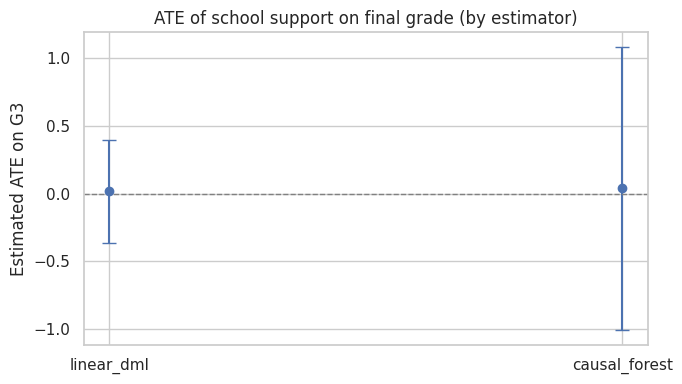

,ate,ate_ci_lower,ate_ci_upper,estimator
0,0.015347,-0.364377,0.395072,linear_dml
1,0.037611,-1.007394,1.082617,causal_forest


In [10]:
# Make a bar plot of ATEs with 95% confidence intervals.

plot_df = ate_df.copy()
plot_df["estimator"] = plot_df.index
plot_df = plot_df.reset_index(drop=True)

plt.figure(figsize=(7, 4))
plt.errorbar(
    x=plot_df["estimator"],
    y=plot_df["ate"],
    yerr=[
        plot_df["ate"] - plot_df["ate_ci_lower"],
        plot_df["ate_ci_upper"] - plot_df["ate"],
    ],
    fmt="o",
    capsize=5,
)
plt.axhline(0, color="gray", linestyle="--", linewidth=1)
plt.ylabel("Estimated ATE on G3")
plt.title("ATE of school support on final grade (by estimator)")
plt.tight_layout()
plt.show()

plot_df

## Average Treatment Effect (ATE)

We estimate the **average causal effect** of extra support on `G3` using two DML estimators:

- **LinearDML** (interpretable baseline)
- **CausalForestDML** (flexible model for non-linear heterogeneity)

**Result:** both estimated ATEs are very close to zero and their confidence intervals include 0. In other words, we do not find strong evidence that extra support has a large average effect on final grades in this dataset.

**Scale interpretation:** since `G3` is on a 0–20 scale, the estimated ATEs correspond to a fraction of a grade point. Interpreted as a percent of the average student’s final grade, the effects are well below 1%, indicating the average impact is small in magnitude.

-   **LinearDML ATE** = **+0.015** grade points (CI includes 0) → about **+0.13% of the average final grade** (~11.91), or **+0.08% of the full 0-20 scale**
-   **CausalForestDML ATE** = **+0.038** grade points (CI includes 0) → about **+0.32% of the average final grade**, or **+0.19% of the 0-20 scale**

## Heterogeneous Effects (CATE) By Subgroup

In [11]:
# Heterogeneity by sex for each estimator
subgroup = "sex"  # 0 = female, 1 = male

cate_by_sex = {}

for est_type, model in models.items():
    cate_df = estimate_cate_by_subgroup(model, df, config, subgroup_col=subgroup)
    cate_df["estimator"] = est_type
    cate_by_sex[est_type] = cate_df

pd.concat(cate_by_sex.values(), ignore_index=True)

,subgroup,cate_mean,cate_std,n,estimator
0,0,-0.218963,0.678218,383,linear_dml
1,1,0.352718,0.728106,266,linear_dml
2,0,0.019334,0.397524,383,causal_forest
3,1,0.063928,0.438444,266,causal_forest


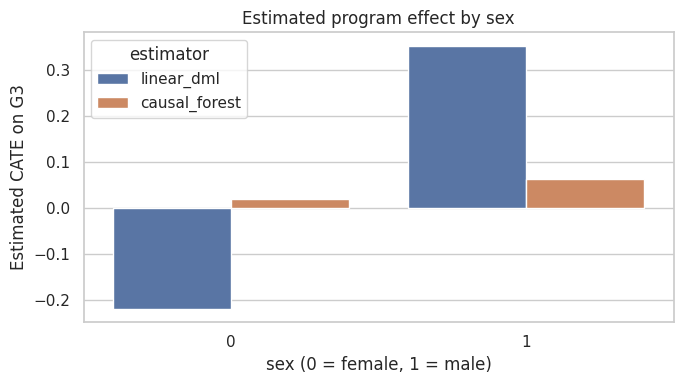

,subgroup,cate_mean,cate_std,n,estimator
0,0,-0.218963,0.678218,383,linear_dml
1,1,0.352718,0.728106,266,linear_dml
2,0,0.019334,0.397524,383,causal_forest
3,1,0.063928,0.438444,266,causal_forest


In [12]:
# Plot CATE by sex
combined_sex = pd.concat(cate_by_sex.values(), ignore_index=True)

plt.figure(figsize=(7, 4))
sns.barplot(
    data=combined_sex,
    x="subgroup",
    y="cate_mean",
    hue="estimator",
)
plt.xlabel("sex (0 = female, 1 = male)")
plt.ylabel("Estimated CATE on G3")
plt.title("Estimated program effect by sex")
plt.tight_layout()
plt.show()

combined_sex

### Heterogeneous effects by gender (`sex`)

We compare mean estimated CATEs by gender. The differences are modest, and the flexible model (CausalForestDML) shows effects near zero for both groups. This suggests that **gender is not a strong driver of benefit** from extra support in this dataset.

In [13]:
# Heterogeneity by Medu (Mother's Education)
subgroup = "Medu"  # ordinal: 0–4
cate_by_medu = {}

for est_type, model in models.items():
    cate_df = estimate_cate_by_subgroup(model, df, config, subgroup_col=subgroup)
    cate_df["estimator"] = est_type
    cate_by_medu[est_type] = cate_df

combined_medu = pd.concat(cate_by_medu.values(), ignore_index=True)
combined_medu.sort_values(["estimator", "subgroup"], inplace=True)
combined_medu

,subgroup,cate_mean,cate_std,n,estimator
5,0,0.387923,0.442333,6,causal_forest
6,1,0.310414,0.359878,143,causal_forest
7,2,0.046506,0.375197,186,causal_forest
8,3,0.073181,0.367949,139,causal_forest
9,4,-0.235024,0.363153,175,causal_forest
0,0,0.910679,0.937557,6,linear_dml
1,1,0.567444,0.764715,143,linear_dml
2,2,0.086232,0.613820,186,linear_dml
3,3,-0.094675,0.729845,139,linear_dml
4,4,-0.454444,0.520921,175,linear_dml


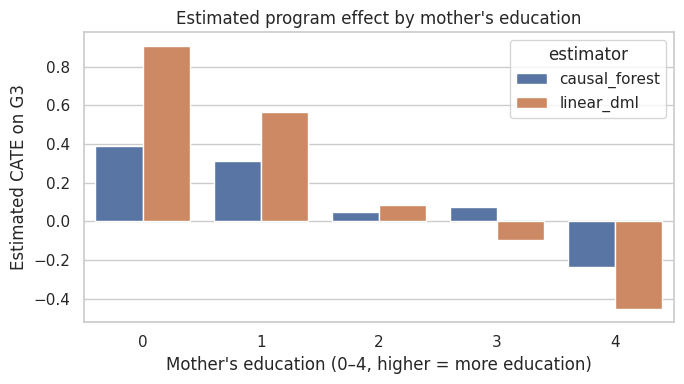

In [14]:
# Plot CATE by Medu
plt.figure(figsize=(7, 4))
sns.barplot(
    data=combined_medu,
    x="subgroup",
    y="cate_mean",
    hue="estimator",
)
plt.xlabel("Mother's education (0–4, higher = more education)")
plt.ylabel("Estimated CATE on G3")
plt.title("Estimated program effect by mother's education")
plt.tight_layout()
plt.show()

### Heterogeneous effects by mother’s education (`Medu`)

We analyze CATE by `Medu` (0–4), a common proxy for socioeconomic background. The pattern suggests that students with **lower parental education** may experience slightly more positive effects, while higher education groups are closer to zero (or slightly negative). Note that very small subgroups (e.g., `Medu=0`) can be noisy.

In [15]:
# Heterogeneity by "higher" (plans for higher education)
subgroup = "higher"  # 0 = no, 1 = yes

cate_by_higher = {}
for est_type, model in models.items():
    cate_df = estimate_cate_by_subgroup(model, df, config, subgroup_col=subgroup)
    cate_df["estimator"] = est_type
    cate_by_higher[est_type] = cate_df

combined_higher = pd.concat(cate_by_higher.values(), ignore_index=True)
combined_higher

,subgroup,cate_mean,cate_std,n,estimator
0,0,1.149379,0.693597,69,linear_dml
1,1,-0.119563,0.637753,580,linear_dml
2,0,0.413389,0.442427,69,causal_forest
3,1,-0.007093,0.388537,580,causal_forest


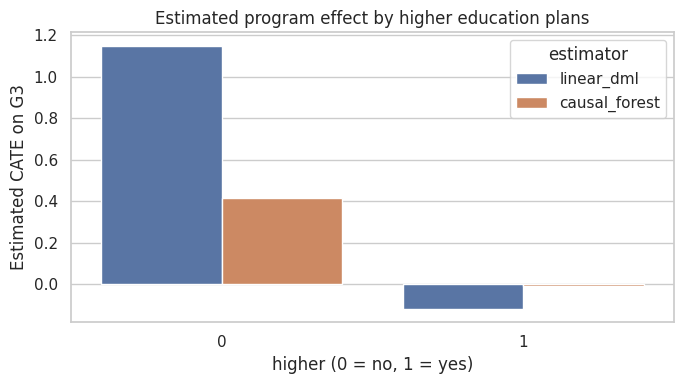

In [16]:
# Plot CATE by Higher Education Plans
plt.figure(figsize=(7, 4))
sns.barplot(
    data=combined_higher,
    x="subgroup",
    y="cate_mean",
    hue="estimator",
)
plt.xlabel("higher (0 = no, 1 = yes)")
plt.ylabel("Estimated CATE on G3")
plt.title("Estimated program effect by higher education plans")
plt.tight_layout()
plt.show()

### Heterogeneous effects by higher-education plans (`higher`)

We split students by whether they plan to pursue higher education (`higher`). The estimated CATEs suggest that students who **do not plan higher education** may benefit more from support than those who do. This is a useful insight because it highlights a group that may be at higher academic risk.

In [17]:
# Heterogeneity by "address"
subgroup = "address"  # 0 = rural, 1 = urban

cate_by_address = {}
for est_type, model in models.items():
    cate_df = estimate_cate_by_subgroup(model, df, config, subgroup_col=subgroup)
    cate_df["estimator"] = est_type
    cate_by_address[est_type] = cate_df

combined_address = pd.concat(cate_by_address.values(), ignore_index=True)
combined_address

,subgroup,cate_mean,cate_std,n,estimator
0,0,0.207924,0.776002,197,linear_dml
1,1,-0.068586,0.727942,452,linear_dml
2,0,0.143355,0.446169,197,causal_forest
3,1,-0.008476,0.392388,452,causal_forest


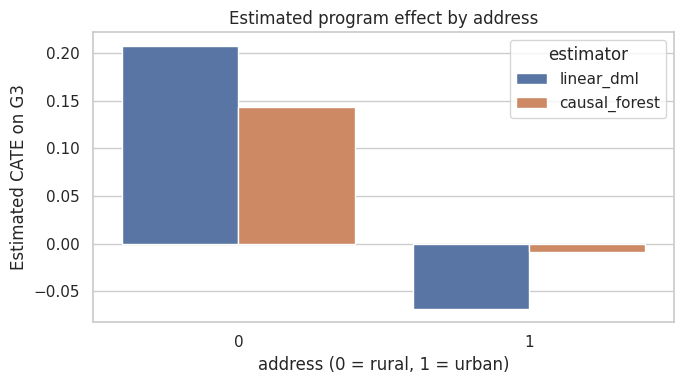

In [18]:
# Plot CATE by address
plt.figure(figsize=(7, 4))
sns.barplot(
    data=combined_address,
    x="subgroup",
    y="cate_mean",
    hue="estimator",
)
plt.xlabel("address (0 = rural, 1 = urban)")
plt.ylabel("Estimated CATE on G3")
plt.title("Estimated program effect by address")
plt.tight_layout()
plt.show()

### Heterogeneous effects by home address (`address`)

We compare estimated effects for rural vs urban students. The subgroup CATEs suggest small differences, with rural students showing slightly higher estimated benefit in the flexible model. As with all subgroup results, these should be interpreted as suggestive patterns rather than definitive causal “targeting rules.”

In [19]:
# Compute and summarize subgroup CATEs 
subgroup_cols = ["sex", "Medu", "address", "higher"]

config.estimator_type = "causal_forest"
main_model = fit_econml_estimator(df, config)

all_subgroups = []

for col in subgroup_cols:
    cate_df = estimate_cate_by_subgroup(main_model, df, config, subgroup_col=col)
    cate_df["feature"] = col
    all_subgroups.append(cate_df)

all_subgroups_df = pd.concat(all_subgroups, ignore_index=True)
all_subgroups_df

,subgroup,cate_mean,cate_std,n,feature
0,0,0.019334,0.397524,383,sex
1,1,0.063928,0.438444,266,sex
2,0,0.387923,0.442333,6,Medu
3,1,0.310414,0.359878,143,Medu
4,2,0.046506,0.375197,186,Medu
5,3,0.073181,0.367949,139,Medu
6,4,-0.235024,0.363153,175,Medu
7,0,0.143355,0.446169,197,address
8,1,-0.008476,0.392388,452,address
9,0,0.413389,0.442427,69,higher


## Identifying which demographics benefit most (subgroup ranking)

To directly support the project objective (“identify which demographics benefit most”), we compute subgroup mean CATEs across multiple demographic/SES variables and **rank subgroups by estimated benefit** (using the CausalForestDML model as our primary heterogeneity estimator).

This provides a single consolidated view of “who benefits most” across:
- `sex`, `Medu`, `address`, `higher`.

The top-ranked subgroups should be interpreted as **candidates for further validation**, not absolute truth, because:
- some subgroups are small (leading to noisy estimates), and
- causal identification still relies on the unconfoundedness assumption.

In [20]:
# Rank subgroups by estimated CATE to see "who benefits most"
all_subgroups_df.sort_values("cate_mean", ascending=False)

,subgroup,cate_mean,cate_std,n,feature
9,0,0.413389,0.442427,69,higher
2,0,0.387923,0.442333,6,Medu
3,1,0.310414,0.359878,143,Medu
7,0,0.143355,0.446169,197,address
5,3,0.073181,0.367949,139,Medu
1,1,0.063928,0.438444,266,sex
4,2,0.046506,0.375197,186,Medu
0,0,0.019334,0.397524,383,sex
10,1,-0.007093,0.388537,580,higher
8,1,-0.008476,0.392388,452,address


## Robustness Check via Cross-Validated ATE

In [21]:
# Kfold ATE Stability for LinearDML
from sklearn.model_selection import KFold

def cross_validated_ate(df, config, n_splits=5, estimator_type="linear_dml"):
    ates = []
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)

    for train_idx, test_idx in kf.split(df):
        train_df = df.iloc[train_idx]
        test_df = df.iloc[test_idx]

        config.estimator_type = estimator_type
        model = fit_econml_estimator(train_df, config)
        ate_res = estimate_ate(model, test_df, config)
        ates.append(ate_res["ate"])

    return np.array(ates)

# Run CV for LinearDML
config.estimator_type = "linear_dml"
cv_ates_linear = cross_validated_ate(df, config, n_splits=5, estimator_type="linear_dml")
cv_ates_linear, cv_ates_linear.mean(), cv_ates_linear.std()

(array([ 0.01338425, -0.13468449,  0.13514701,  0.11803138, -0.04753486]),
 np.float64(0.01686865882566971),
 np.float64(0.10134295969748423))

In [22]:
# Comparison for CausalForestDML
config.estimator_type = "causal_forest"
cv_ates_forest = cross_validated_ate(df, config, n_splits=5, estimator_type="causal_forest")
cv_ates_forest, cv_ates_forest.mean(), cv_ates_forest.std()

(array([-0.12173275, -0.1111306 ,  0.13755947, -0.10437347,  0.06395763]),
 np.float64(-0.027143941905621173),
 np.float64(0.10713721355904136))

## Robustness check: cross-validated ATE

We compute 5-fold cross-validated ATEs for both estimators. The fold level ATEs stay within a narrow band around zero, and the fold-to-fold standard deviation is small (~0.10 grade points).

This supports the conclusion that the **overall effect is small**, and that our ATE estimate is not driven by a single train/test split.

# Summary and limitations

**Key takeaways**
- The **average effect (ATE)** of extra support on final grades is **small** in magnitude in this dataset.
- The **largest positive subgroup CATEs** are associated with specific demographics/SES proxies (notably `higher` and lower `Medu`), suggesting potential targeting directions.
- Gender differences appear modest.

**Limitations**
- Observational identification: estimates assume we have measured the key confounders.
- Some subgroups are small (e.g., `Medu=0`), making estimates noisy.
- “Extra support” is a coarse treatment definition; real programs may differ in intensity/quality.